# Import Library

In [276]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.forecasting.stl import STLForecast

In [277]:
start_date = datetime(2005, 1, 1)
end_date = datetime(2021, 1, 1)

df = yf.download(
  'SPY', 
  start = start_date,
  end = end_date
)

[*********************100%%**********************]  1 of 1 completed


In [278]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,121.559998,121.760002,119.900002,120.300003,83.364357,55748000
2005-01-04,120.459999,120.540001,118.440002,118.830002,82.345726,69167600
2005-01-05,118.739998,119.250000,118.000000,118.010002,81.777443,65667300
2005-01-06,118.440002,119.150002,118.260002,118.610001,82.193237,47814700
2005-01-07,118.970001,119.230003,118.129997,118.440002,82.075447,55847700
...,...,...,...,...,...,...
2020-12-24,368.079987,369.029999,367.450012,369.000000,351.874756,26457900
2020-12-28,371.739990,372.589996,371.070007,372.170013,354.897675,39000400
2020-12-29,373.809998,374.000000,370.829987,371.459991,354.220520,53680500


Text(0.5, 0, 'Date')

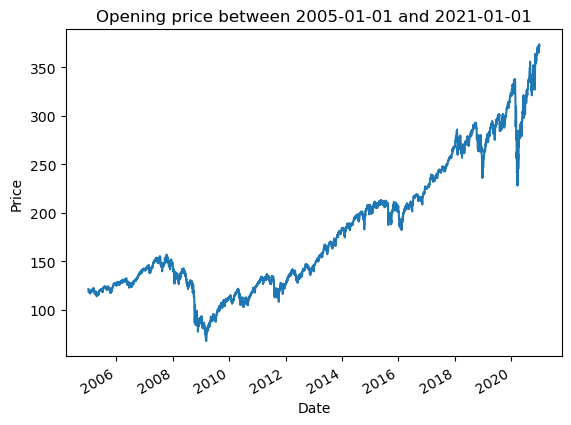

In [279]:
plt.title('Opening price between {} and {}'.format(start_date.date().isoformat(), end_date.date().isoformat()))
df['Open'].plot()
plt.ylabel('Price')
plt.xlabel('Date')

In [280]:
# resample the data to weekly data and make each year consistent
df1 = df.reset_index().resample('W', on = 'Date')['Open'].mean()

In [281]:
# df1 = df1[df1.index.week < 53]
df1

Date
2005-01-09    119.634000
2005-01-16    118.398000
2005-01-23    118.290001
2005-01-30    117.200000
2005-02-06    118.663998
                 ...    
2020-12-06    365.444000
2020-12-13    367.577997
2020-12-20    369.754004
2020-12-27    367.384995
2021-01-03    372.417496
Freq: W-SUN, Name: Open, Length: 835, dtype: float64

In [282]:
cond = df1.index.isocalendar().week < 53
df1 = df1[cond]

In [283]:
df1 = df1.asfreq('W').fillna(method = 'ffill')

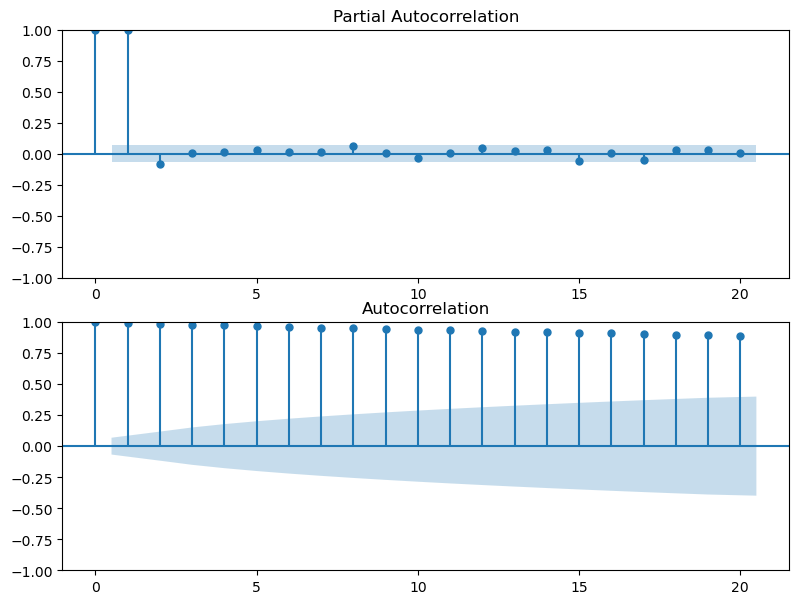

In [284]:
fig, axes = plt.subplots(nrows = 2, figsize = (8,6))
fig.tight_layout()
sm.graphics.tsa.plot_pacf(df1, lags = 20, ax = axes[0])
sm.graphics.tsa.plot_acf(df1, lags = 20, ax = axes[1])
plt.show()

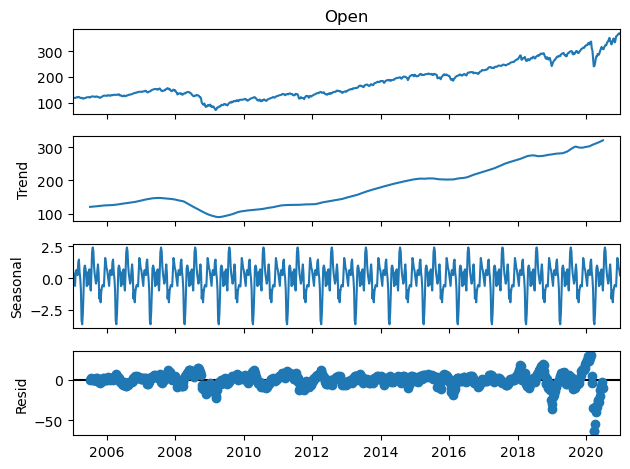

In [285]:
result = seasonal_decompose(df1, model = 'additive', period = 52)
result.plot()
plt.show()

In [286]:
# to establish stationarity, need to remove the seasonL or trend components 
# or we can use wrapper in statsmodels or set the d parameter in ARIMA

# use Augmented Dickey-Fuller and KPSS tests to check for stationarity 
from arch.unitroot import KPSS, ADF
ADF(df1)

Test Statistic,1.325
P-value,0.997
Lags,9


In [287]:
mod  = sm.tsa.arima.ARIMA(endog = df1, order = (1, 0, 0))
res = mod.fit()
# the AR model is not stationary

c:\Users\julia\miniconda3\envs\pythontest1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [288]:
# use STLForevercast wrapper to remove the seasonality and then add it back
mod1 = STLForecast(
  df1,
  sm.tsa.arima.ARIMA,
  model_kwargs = dict(order = (1, 1, 0), trend = 't')
)
res1 = mod1.fit().model_result
print(res1.summary())
# using AIC and BIC to select the model

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  834
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1965.555
Date:                Fri, 29 Mar 2024   AIC                           3937.110
Time:                        13:42:09   BIC                           3951.285
Sample:                    01-09-2005   HQIC                          3942.545
                         - 12-27-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2771      0.119      2.327      0.020       0.044       0.511
ar.L1          0.2502      0.022     11.402      0.000       0.207       0.293
sigma2         6.5618      0.184     35.641      0.0

In [289]:
res2 = mod1.fit()
res2.forecast(20)
# forecast method gives only point forecast
# should use get_forecast(), because get_forecast() is more general,
# and also allows constructing confidence intervals, but both of them allow many steps

2021-01-03    348.932407
2021-01-10    354.653727
2021-01-17    359.794657
2021-01-24    363.504008
2021-01-31    359.770830
2021-02-07    362.272719
2021-02-14    365.733089
2021-02-21    368.023379
2021-02-28    352.189735
2021-03-07    345.557944
2021-03-14    327.124488
2021-03-21    307.218550
2021-03-28    306.005891
2021-04-04    313.935151
2021-04-11    325.553077
2021-04-18    333.229237
2021-04-25    332.477451
2021-05-02    338.582624
2021-05-09    335.269449
2021-05-16    333.590695
Freq: W-SUN, dtype: float64

In [290]:
steps = 20
forecast_df1 = res.get_forecast(steps = steps).summary_frame()
forecast_df1

Open,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-01-03,367.302012,3.611343,360.223910,374.380114
2021-01-10,367.219067,5.106065,357.211364,377.226771
2021-01-17,367.136159,6.252225,354.882024,379.390295
2021-01-24,367.053289,7.217829,352.906604,381.199974
2021-01-31,366.970455,8.067970,351.157525,382.783385
2021-02-07,366.887659,8.836037,349.569344,384.205973
2021-02-14,366.804899,9.541872,348.103173,385.506626
2021-02-21,366.722177,10.198405,346.733670,386.710685
2021-02-28,366.639492,10.814619,345.443228,387.835757
2021-03-07,366.556844,11.397057,344.219024,388.894665


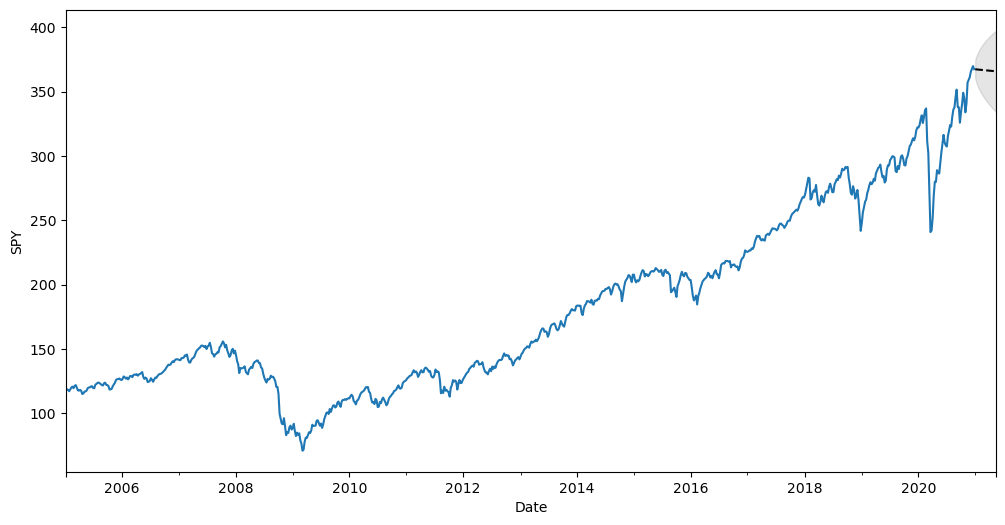

In [291]:
# visualize forecast
ax = df1.plot(figsize = (12, 6))
plt.ylabel('SPY')
forecast_df1['mean'].plot(style = 'k--')
ax.fill_between(
  forecast_df1.index,
  forecast_df1['mean_ci_lower'],
  forecast_df1['mean_ci_upper'],
  color = 'k',
  alpha = 0.1
)
plt.show()

In [292]:
def jra_get_value(table, value):
  value = value.lower()
  value = re.sub(pattern = '[()]', repl = '', string = value)
  str = table.as_text().lower()
  str = re.sub(pattern = '[()]', repl = '', string = str)
  pattern = value + '\S*[ ]+([^ |\n]*)'
  try:
    x = re.findall(pattern = pattern, string = str)
    x = x[0] if len(x) == 1 else ''
  except:
    x = ''
  return x

In [293]:
forecasts = []

qs = []

for q in range(0, 30, 10):
  mod = STLForecast(
    df1,
    sm.tsa.arima.ARIMA,
    model_kwargs = dict(order = (0, 1, q), trend = 't')
  )
  res = mod.fit()
  print(f"aic ({q}): {jra_get_value(res.summary(), 'AIC')}")
  forecasts.append(res.get_forecast(steps = steps).summary_frame()['mean'])

aic (0): 3989.010


AttributeError: 'STLForecastResults' object has no attribute 'get_forecast'

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import re

In [ ]:
q = 10
mod = STLForecast(
  endog = df1,
  model = ARIMA,
  model_kwargs = None
)
res = mod.fit()

In [ ]:
results = res.summary()
results

<class 'statsmodels.iolib.summary.Summary'>
"""
                    STL Decomposition and SARIMAX Results                     
==============================================================================
Dep. Variable:                      y   No. Observations:                  834
Model:                          ARIMA   Log Likelihood               -4704.162
Date:                Thu, 28 Mar 2024   AIC                           9412.324
Time:                        21:05:33   BIC                           9421.776
Sample:                    01-09-2005   HQIC                          9415.948
                         - 12-27-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        180.9403      2.933     61.692      0.000     175.192     186.689
sigma2      4642.5600    353.309     13.140      0.000    3950.088    5335.032
===================================================================================
Ljung-Box (L1) (Q):                 828.87   Jarque-Bera (JB):                80.81
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.26   Skew:                             0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.28
                                STL Configuration                                
=================================================================================
Period:                            52       Trend Length:                     101
Seasonal:                           7       Trend deg:                          1
Seasonal deg:                       1       Trend jump:                         1
Seasonal jump:                      1       Low pass:                          53
Robust:                         False       Low pass deg:                       1
---------------------------------------------------------------------------------

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
'sdS'.lower()

'sds'

In [ ]:
AIC = jra_get_value(results, 'AIC')
AIC = float(AIC)
AIC

9412.324